![Logo dell'Università XYZ](img/logo.jpg)

# Advanced Financial Modeling Course

## Introduction

This notebook is part of the teaching material of the Advanced Financial Modeling course! In this series of Jupyter notebooks, we will cover various topics related to financial modeling, including fundamental concepts, practical applications, and hands-on exercises.

### Notebooks Overview

1. [Notebook 1: Curve Building](notebooks/notebook1.ipynb)
2. [Notebook 2: AAD Greeks](notebooks/notebook2.ipynb)
3. [Notebook 3: Swap AAD Sensitivities](notebooks/notebook3.ipynb)
3. [Notebook 4: Simulation of Extended Short-Rate Models](notebooks/notebook3.ipynb)
4. [Notebook 5: Model Calibration](notebooks/notebook4.ipynb)
5. [Notebook 6: SABR stochastic volatility](notebooks/notebook5.ipynb)
5. [Notebook 7: xVA--CCR simulation](notebooks/notebook5.ipynb)


## Notebook 3: Swap AAD Sensitivities 

This notebook provides an in-depth exploration of curve building in the context of interest rate modeling. We'll cover fundamental concepts and techniques for constructing interest rate curves, with a practical example focused on the EUR market.

### Topics Covered

- Understanding interest rate curves and their significance in financial modeling.
- Utilizing QuantLib library to handle financial data and perform curve building tasks.
- Principles of discounting and forwarding, essential for curve construction and valuation.
- Interpolation methods for smoothing and extrapolating curve data.




## Settings

In [1]:
from util import tquant as tq

import tensorflow as tf
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt

general settings

In [2]:
calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

load market data

In [3]:
mdl = tq.MarketDataLoader('20230929')
rates = mdl.ir_eur_curve_estr['quote'].values
times = mdl.ir_eur_curve_estr['daycount'].values/365 # /365 for convenience

rates_6m = mdl.ir_eur_curve_6m['quote'].values
times_6m = mdl.ir_eur_curve_6m['daycount'].values/365

estr_curve = tq.RateCurve(times, rates)
eur6m_curve = tq.RateCurve(times_6m, rates_6m)

fixed leg informations

In [4]:
# --------------
# fixed leg
start_date = date(2015,12,31)
fixed_schedule = [start_date]
fixed_schedule.extend([start_date + timedelta(365 *.5 *i) for i in range(1,51)])
fixed_rate = [0.04156]*(len(fixed_schedule)-1)
fixed_notional = [143857602,142099704,140995554,139343227,138170625,136487409,135100610,133235348,131633135,130088055,
                128443001,126527961,124478813,122046073,119540895,117334856,115325682,113682288,112374057,110400222,108996590,
                107427609,106277787,104934949,103826978,102318265,101011839,99241108,97427949,95062460,92643968,89488286,86306759,
                82654668,79233393,75249260,71491885,67239725,63147273,58562602,54101515,49235670,44484930,39276217,34122360,28587822,
                23186787,17327243,11581997,5627771]
fixed_notional = [-1*n for n in fixed_notional] ## check
fixed_daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)

floating leg informations

In [5]:
# --------------
# floating leg
floating_schedule = [start_date]
floating_schedule.extend([start_date + timedelta(365 *.5 *i) for i in range(1,51)])

floating_notional = [0,0,0,0,0,0,0,0,0,0,
    128443001,126527961,124478813,122046073,119540895,117334856,115325682,113682288,112374057,110400222,108996590,
    107427609,106277787,104934949,103826978,102318265,101011839,99241108,97427949,95062460,92643968,89488286,86306759,
    82654668,79233393,75249260,71491885,67239725,63147273,58562602,54101515,49235670,44484930,39276217,34122360,28587822,
    23186787,17327243,11581997,5627771]

index_6m = tq.IborIndex('EUR6M',
                        calendar,
                        6,
                        tq.TimeUnit.Months)
spread = [0.] *(len(floating_schedule)-1)
gearing = [1.] *(len(floating_schedule)-1)
floating_daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)

Historical fixing

In [6]:
# --------------
# fixing
index_6m.add_fixing(date(2023, 6,29), 0.03)

Swap object

In [7]:
# --------------
# swap object

swap = tq.InterestRateSwap(floating_schedule, fixed_schedule,
                            floating_notional, fixed_notional, gearing, spread,
                            index_6m, fixed_rate, fixed_daycounter, floating_daycounter)

Swap pricer

In [8]:
swap_engine = tq.SwapAnalyticEngine(swap)

In [9]:
npv_swap = swap_engine.price(estr_curve, eur6m_curve, evaluation_date)

In [10]:
floating_leg_pricer = tq.FloatingLegDiscounting(swap.floating_leg)
fixed_leg_pricer = tq.FixedLegDiscounting(swap.fixed_leg)

npv_float = floating_leg_pricer.price(estr_curve, eur6m_curve, evaluation_date, tq.FloatingCouponDiscounting)
npv_fixed = fixed_leg_pricer.price(estr_curve, evaluation_date, tq.FixedCouponDiscounting)

print(f"NPV FixedLeg: {npv_fixed :,.0f}")
print(f"NPV FloatingLeg: {npv_float :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: -43,902,379
NPV FloatingLeg: 36,315,279
NPV Swap: -7,587,101


In [11]:
npv_swap, tape = swap_engine.price_aad(estr_curve, eur6m_curve, evaluation_date)
sensitivities = tape.gradient(npv_swap, [estr_curve.rates, eur6m_curve.rates])

In [12]:
# Function to extract values from TensorFlow tensors
def extract_value(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()  # Extract value from TensorFlow tensor
    else:
        return x

In [13]:
sensy_estr = pd.DataFrame([estr_curve.pillars.tolist(), sensitivities[0]]).T
sensy_estr.columns = ['time', 'sensy_estr']
sensy_estr.fillna(0, inplace = True)
sensy_estr.set_index('time', inplace = True)
sensy_estr['sensy_estr'] = sensy_estr['sensy_estr'].apply(extract_value)

sensy_eur6m = pd.DataFrame([eur6m_curve.pillars.tolist(), sensitivities[1]]).T
sensy_eur6m.columns = ['time', 'sensy_eur6m']
sensy_eur6m.fillna(0, inplace = True)
sensy_eur6m.set_index('time', inplace = True)
sensy_eur6m['sensy_eur6m'] = sensy_eur6m['sensy_eur6m'].apply(extract_value)

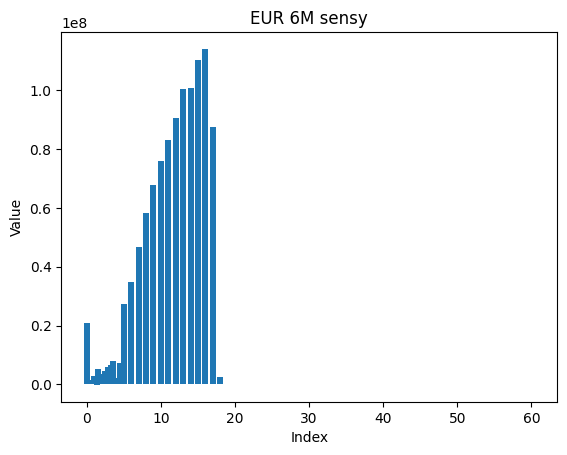

In [14]:
# Plot line chart of column 'A'
plt.bar(sensy_eur6m.index, sensy_eur6m['sensy_eur6m'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('EUR 6M sensy')
plt.show()

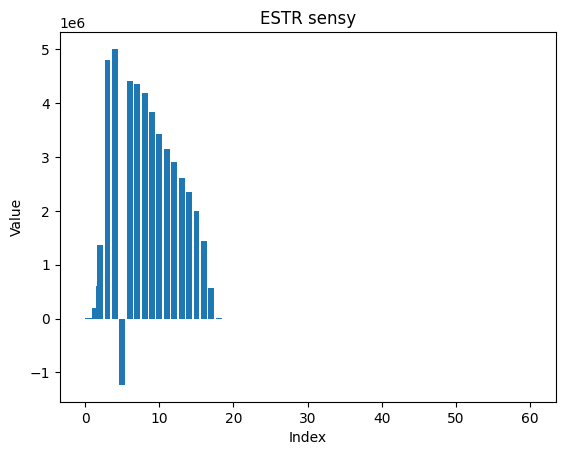

In [15]:

plt.bar(sensy_estr.index, sensy_estr['sensy_estr'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ESTR sensy')
plt.show()

# Tensor Pricing 

## simulate random 1M curves

In [16]:
# instance of the hull-white model for 1M curve simulation
mean_rev = 0.02
sigma = 0.045
hw = tq.HullWhiteProcess(mean_rev, sigma, market_curve=estr_curve)
hw_kernel = tq.GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) # evaluation_date + 1y
# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(zb_tensor.shape[1], paths, 1))
rate_curve_tensor = tq.DiscountCurveSimple(times, reshaped_tensor)

## swap price for 1M simulated curves

In [17]:
npv_swap = swap_engine.price(rate_curve_tensor, rate_curve_tensor, evaluation_date)

In [18]:
npv_swap

<tf.Tensor: shape=(1000000, 1), dtype=float64, numpy=
array([[ -6750717.49403729],
       [    56560.48928215],
       [-12576244.17575634],
       ...,
       [-48718978.75072677],
       [ 21922158.75598115],
       [ 19948289.11218137]])>

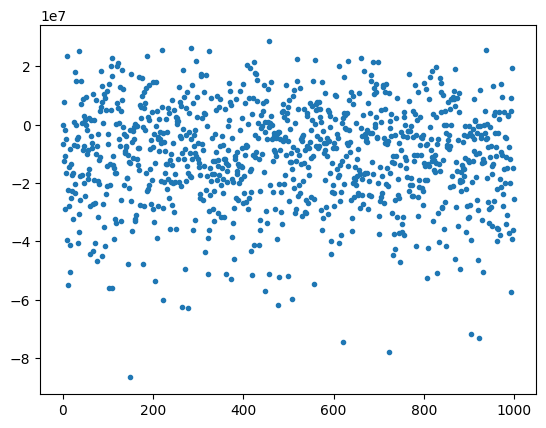

In [19]:
plt.plot(npv_swap[:1000], '.');